# Tensorflow.keras implementation of full precision CNN for CIFAR 100 
##  https://arxiv.org/abs/1802.08530
## M. D. McDonnell, 
## Training wide residual networks for deployment using a single bit for each weight
## ICLR, 2018

In [1]:
# select a GPU
import os
os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import tensorflow
print('Tensorflow version = ',tensorflow.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, History

#from tensorflow.keras import backend as K

from ResNetModel import resnet
from Utils import cutout,LR_WarmRestart,GetDataGen,plot_history

Tensorflow version =  1.13.1


In [2]:
#params
#WhichDataSet = 'CIFAR10'
WhichDataSet = 'CIFAR100'
init_lr = 0.1
epochs = 254
batch_size = 125
My_wd=5e-4/2
resnet_width = 10
resnet_depth = 20
UseBinary=False
UseCutout=True
Loss = 'categorical_crossentropy'
Optimizer = SGD(lr=init_lr,decay=0.0, momentum=0.9, nesterov=False)
Metrics = ['accuracy']
ModelsPath = 'TrainedModels/Tensorflow.keras/'

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
#load and prepare data
if WhichDataSet == 'CIFAR10':
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar10.load_data()
else:
    (x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.cifar100.load_data()
num_classes = np.unique(y_train).shape[0]
K_train = x_train.shape[0]
input_shape = x_train.shape[1:]
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)


In [4]:
#fdefine a datagen or generating training samples with flip and pad/crop augmentation, and if set to True, with cutout augmentation
dataGenerator = GetDataGen(UseCutout)

#define and compile the model
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

#print  the model
model.summary()

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [1.0,3.0, 7.0, 15.0, 31.0, 63.0,127.0,255.0]) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 160)  4320        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, 32, 32, 160)  320         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

In [5]:
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)

Instructions for updating:
Use tf.cast instead.

 Start of Epoch Learning Rate = 0.100000
Epoch 1/254
10000/10000 [==============================] - 6s 615us/sample - loss: 6.2883 - acc: 0.1525

 End of Epoch Learning Rate = 0.050005
400/400 [==============================] - 108s 270ms/step - loss: 6.7487 - acc: 0.1437 - val_loss: 6.2883 - val_acc: 0.1525

 Start of Epoch Learning Rate = 0.050005
Epoch 2/254
10000/10000 [==============================] - 6s 584us/sample - loss: 5.0996 - acc: 0.3595

 End of Epoch Learning Rate = 0.000010
400/400 [==============================] - 104s 260ms/step - loss: 5.5200 - acc: 0.2821 - val_loss: 5.0996 - val_acc: 0.3595

 Start of Epoch Learning Rate = 0.100000
Epoch 3/254
10000/10000 [==============================] - 6s 581us/sample - loss: 4.8342 - acc: 0.2641

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 104s 259ms/step - loss: 5.1731 - acc: 0.2734 - val_loss: 4.8342 - val_acc: 0.2641

 Start of Epoch Le

10000/10000 [==============================] - 6s 576us/sample - loss: 1.7901 - acc: 0.7175

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 103s 257ms/step - loss: 1.5662 - acc: 0.7824 - val_loss: 1.7901 - val_acc: 0.7175

 Start of Epoch Learning Rate = 0.022229
Epoch 53/254
10000/10000 [==============================] - 6s 576us/sample - loss: 1.7791 - acc: 0.7220

 End of Epoch Learning Rate = 0.018289
400/400 [==============================] - 103s 257ms/step - loss: 1.4975 - acc: 0.7968 - val_loss: 1.7791 - val_acc: 0.7220

 Start of Epoch Learning Rate = 0.018289
Epoch 54/254
10000/10000 [==============================] - 6s 577us/sample - loss: 1.7654 - acc: 0.7158

 End of Epoch Learning Rate = 0.014653
400/400 [==============================] - 103s 257ms/step - loss: 1.4008 - acc: 0.8182 - val_loss: 1.7654 - val_acc: 0.7158

 Start of Epoch Learning Rate = 0.014653
Epoch 55/254
10000/10000 [==============================] - 6s 577us/sample -

10000/10000 [==============================] - 6s 575us/sample - loss: 2.0241 - acc: 0.6763

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 103s 257ms/step - loss: 1.5256 - acc: 0.8036 - val_loss: 2.0241 - val_acc: 0.6763

 Start of Epoch Learning Rate = 0.026438
Epoch 105/254
10000/10000 [==============================] - 6s 576us/sample - loss: 2.1100 - acc: 0.6679

 End of Epoch Learning Rate = 0.024302
400/400 [==============================] - 103s 257ms/step - loss: 1.4875 - acc: 0.8108 - val_loss: 2.1100 - val_acc: 0.6679

 Start of Epoch Learning Rate = 0.024302
Epoch 106/254
10000/10000 [==============================] - 6s 575us/sample - loss: 1.9867 - acc: 0.6911

 End of Epoch Learning Rate = 0.022229
400/400 [==============================] - 103s 257ms/step - loss: 1.4321 - acc: 0.8239 - val_loss: 1.9867 - val_acc: 0.6911

 Start of Epoch Learning Rate = 0.022229
Epoch 107/254
10000/10000 [==============================] - 6s 576us/sampl

10000/10000 [==============================] - 6s 574us/sample - loss: 3.3802 - acc: 0.4560

 End of Epoch Learning Rate = 0.087049
400/400 [==============================] - 103s 258ms/step - loss: 2.2883 - acc: 0.6700 - val_loss: 3.3802 - val_acc: 0.4560

 Start of Epoch Learning Rate = 0.087049
Epoch 157/254
10000/10000 [==============================] - 6s 575us/sample - loss: 3.2261 - acc: 0.4731

 End of Epoch Learning Rate = 0.086214
400/400 [==============================] - 103s 257ms/step - loss: 2.2664 - acc: 0.6757 - val_loss: 3.2261 - val_acc: 0.4731

 Start of Epoch Learning Rate = 0.086214
Epoch 158/254
10000/10000 [==============================] - 6s 573us/sample - loss: 2.7526 - acc: 0.5550

 End of Epoch Learning Rate = 0.085357
400/400 [==============================] - 103s 257ms/step - loss: 2.2695 - acc: 0.6761 - val_loss: 2.7526 - val_acc: 0.5550

 Start of Epoch Learning Rate = 0.085357
Epoch 159/254
10000/10000 [==============================] - 6s 576us/sampl

10000/10000 [==============================] - 6s 576us/sample - loss: 2.2850 - acc: 0.6313

 End of Epoch Learning Rate = 0.028629
400/400 [==============================] - 103s 257ms/step - loss: 1.5081 - acc: 0.8155 - val_loss: 2.2850 - val_acc: 0.6313

 Start of Epoch Learning Rate = 0.028629
Epoch 209/254
10000/10000 [==============================] - 6s 583us/sample - loss: 2.2747 - acc: 0.6387

 End of Epoch Learning Rate = 0.027527
400/400 [==============================] - 103s 257ms/step - loss: 1.4769 - acc: 0.8239 - val_loss: 2.2747 - val_acc: 0.6387

 Start of Epoch Learning Rate = 0.027527
Epoch 210/254
10000/10000 [==============================] - 6s 583us/sample - loss: 2.2281 - acc: 0.6537

 End of Epoch Learning Rate = 0.026438
400/400 [==============================] - 103s 258ms/step - loss: 1.4666 - acc: 0.8230 - val_loss: 2.2281 - val_acc: 0.6537

 Start of Epoch Learning Rate = 0.026438
Epoch 211/254
10000/10000 [==============================] - 6s 579us/sampl

In [6]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 83.02


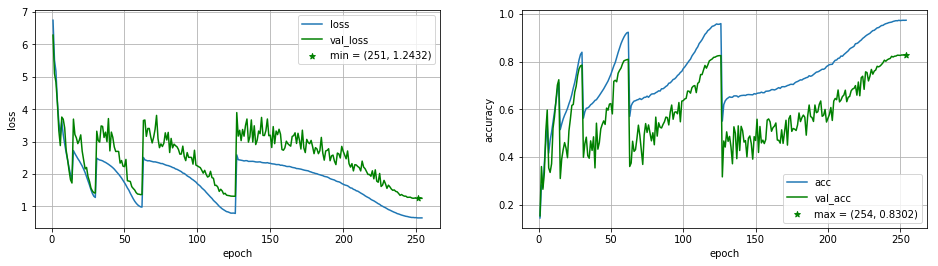

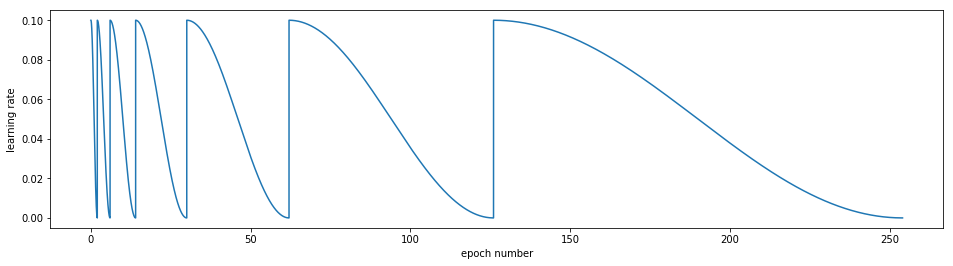

In [7]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()

In [8]:
#save the weigts used for updating
model.save_weights(ModelsPath+'Final_weights_'+WhichDataSet+'_32bit_model_v2.h5')

In [11]:
#try again without warm restart wth 300 epochs cosine schedule
model = resnet(UseBinary,input_shape=input_shape, depth=resnet_depth, num_classes=num_classes,wd=My_wd,width=resnet_width)
model.compile(loss=Loss ,optimizer = Optimizer, metrics = Metrics)

epochs=300

#define the learnng rate schedule
steps_per_epoch = int(np.floor(K_train / batch_size))
lr_scheduler = LR_WarmRestart(nbatch=steps_per_epoch,
                              initial_lr=init_lr, min_lr=init_lr*1e-4,
                              epochs_restart = [],
                              Tmult=300.0) 

#define callbacks
history = History()
callbacks = [lr_scheduler,history]
history = model.fit_generator(dataGenerator.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_test, y_test),
                              epochs=epochs,
                              verbose=1,
                              callbacks=callbacks,
                              steps_per_epoch =steps_per_epoch)


 Start of Epoch Learning Rate = 0.100000
Epoch 1/300
10000/10000 [==============================] - 6s 618us/sample - loss: 6.1005 - acc: 0.1498

 End of Epoch Learning Rate = 0.099997
400/400 [==============================] - 104s 259ms/step - loss: 6.7230 - acc: 0.1406 - val_loss: 6.1005 - val_acc: 0.1498

 Start of Epoch Learning Rate = 0.099997
Epoch 2/300
10000/10000 [==============================] - 6s 578us/sample - loss: 4.8708 - acc: 0.2511

 End of Epoch Learning Rate = 0.099989
400/400 [==============================] - 101s 253ms/step - loss: 5.2212 - acc: 0.2609 - val_loss: 4.8708 - val_acc: 0.2511

 Start of Epoch Learning Rate = 0.099989
Epoch 3/300
10000/10000 [==============================] - 6s 578us/sample - loss: 4.4465 - acc: 0.2617

 End of Epoch Learning Rate = 0.099975
400/400 [==============================] - 101s 254ms/step - loss: 4.2937 - acc: 0.3390 - val_loss: 4.4465 - val_acc: 0.2617

 Start of Epoch Learning Rate = 0.099975
Epoch 4/300
10000/10000 [

10000/10000 [==============================] - 6s 578us/sample - loss: 3.2558 - acc: 0.4463

 End of Epoch Learning Rate = 0.092495
400/400 [==============================] - 102s 254ms/step - loss: 2.3213 - acc: 0.6487 - val_loss: 3.2558 - val_acc: 0.4463

 Start of Epoch Learning Rate = 0.092495
Epoch 54/300
10000/10000 [==============================] - 6s 581us/sample - loss: 3.3662 - acc: 0.4369

 End of Epoch Learning Rate = 0.092217
400/400 [==============================] - 102s 254ms/step - loss: 2.3081 - acc: 0.6524 - val_loss: 3.3662 - val_acc: 0.4369

 Start of Epoch Learning Rate = 0.092217
Epoch 55/300
10000/10000 [==============================] - 6s 580us/sample - loss: 3.3159 - acc: 0.4349

 End of Epoch Learning Rate = 0.091934
400/400 [==============================] - 102s 254ms/step - loss: 2.3154 - acc: 0.6506 - val_loss: 3.3159 - val_acc: 0.4349

 Start of Epoch Learning Rate = 0.091934
Epoch 56/300
10000/10000 [==============================] - 6s 578us/sample -

10000/10000 [==============================] - 6s 574us/sample - loss: 2.9448 - acc: 0.5254

 End of Epoch Learning Rate = 0.072702
400/400 [==============================] - 101s 254ms/step - loss: 2.1417 - acc: 0.6937 - val_loss: 2.9448 - val_acc: 0.5254

 Start of Epoch Learning Rate = 0.072702
Epoch 106/300
10000/10000 [==============================] - 6s 574us/sample - loss: 2.8905 - acc: 0.5285

 End of Epoch Learning Rate = 0.072235
400/400 [==============================] - 101s 254ms/step - loss: 2.1297 - acc: 0.6981 - val_loss: 2.8905 - val_acc: 0.5285

 Start of Epoch Learning Rate = 0.072235
Epoch 107/300
10000/10000 [==============================] - 6s 579us/sample - loss: 2.9278 - acc: 0.5090

 End of Epoch Learning Rate = 0.071764
400/400 [==============================] - 102s 254ms/step - loss: 2.1222 - acc: 0.7007 - val_loss: 2.9278 - val_acc: 0.5090

 Start of Epoch Learning Rate = 0.071764
Epoch 108/300
10000/10000 [==============================] - 6s 577us/sampl

10000/10000 [==============================] - 6s 578us/sample - loss: 2.8544 - acc: 0.5516

 End of Epoch Learning Rate = 0.046343
400/400 [==============================] - 101s 254ms/step - loss: 1.8050 - acc: 0.7638 - val_loss: 2.8544 - val_acc: 0.5516

 Start of Epoch Learning Rate = 0.046343
Epoch 158/300
10000/10000 [==============================] - 6s 577us/sample - loss: 2.6866 - acc: 0.5802

 End of Epoch Learning Rate = 0.045822
400/400 [==============================] - 102s 254ms/step - loss: 1.8042 - acc: 0.7658 - val_loss: 2.6866 - val_acc: 0.5802

 Start of Epoch Learning Rate = 0.045822
Epoch 159/300
10000/10000 [==============================] - 6s 577us/sample - loss: 2.7290 - acc: 0.5741

 End of Epoch Learning Rate = 0.045300
400/400 [==============================] - 101s 254ms/step - loss: 1.7937 - acc: 0.7668 - val_loss: 2.7290 - val_acc: 0.5741

 Start of Epoch Learning Rate = 0.045300
Epoch 160/300
10000/10000 [==============================] - 6s 569us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 6s 577us/sample - loss: 2.4341 - acc: 0.6196

 End of Epoch Learning Rate = 0.028718
400/400 [==============================] - 102s 254ms/step - loss: 1.4770 - acc: 0.8273 - val_loss: 2.4341 - val_acc: 0.6196

 Start of Epoch Learning Rate = 0.028718
Epoch 193/300
10000/10000 [==============================] - 6s 573us/sample - loss: 2.2307 - acc: 0.6548

 End of Epoch Learning Rate = 0.028246
400/400 [==============================] - 102s 254ms/step - loss: 1.4651 - acc: 0.8306 - val_loss: 2.2307 - val_acc: 0.6548

 Start of Epoch Learning Rate = 0.028246
Epoch 194/300
10000/10000 [==============================] - 6s 579us/sample - loss: 2.4723 - acc: 0.6085

 End of Epoch Learning Rate = 0.027775
400/400 [==============================] - 102s 254ms/step - loss: 1.4597 - acc: 0.8328 - val_loss: 2.4723 - val_acc: 0.6085

 Start of Epoch Learning Rate = 0.027775
Epoch 195/300
10000/10000 [==============================] - 6s 576us/sampl

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10000/10000 [==============================] - 6s 575us/sample - loss: 2.1835 - acc: 0.6566

 End of Epoch Learning Rate = 0.021044
400/400 [==============================] - 102s 254ms/step - loss: 1.2879 - acc: 0.8649 - val_loss: 2.1835 - val_acc: 0.6566

 Start of Epoch Learning Rate = 0.021044
Epoch 210/300
10000/10000 [==============================] - 6s 578us/sample - loss: 2.0310 - acc: 0.6823

 End of Epoch Learning Rate = 0.020619
400/400 [==============================] - 102s 254ms/step - loss: 1.2876 - acc: 0.8622 - val_loss: 2.0310 - val_acc: 0.6823

 Start of Epoch Learning Rate = 0.020619
Epoch 211/300
10000/10000 [==============================] - 6s 578us/sample - loss: 2.3573 - acc: 0.6148

 End of Epoch Learning Rate = 0.020197
400/400 [==============================] - 101s 254ms/step - loss: 1.2697 - acc: 0.8669 - val_loss: 2.3573 - val_acc: 0.6148

 Start of Epoch Learning Rate = 0.020197
Epoch 212/300
10000/10000 [==============================] - 6s 578us/sampl

10000/10000 [==============================] - 6s 576us/sample - loss: 1.4304 - acc: 0.7885

 End of Epoch Learning Rate = 0.004122
400/400 [==============================] - 102s 254ms/step - loss: 0.6740 - acc: 0.9603 - val_loss: 1.4304 - val_acc: 0.7885

 Start of Epoch Learning Rate = 0.004122
Epoch 262/300
10000/10000 [==============================] - 6s 574us/sample - loss: 1.4059 - acc: 0.7848

 End of Epoch Learning Rate = 0.003916
400/400 [==============================] - 102s 254ms/step - loss: 0.6706 - acc: 0.9584 - val_loss: 1.4059 - val_acc: 0.7848

 Start of Epoch Learning Rate = 0.003916
Epoch 263/300
10000/10000 [==============================] - 6s 575us/sample - loss: 1.4336 - acc: 0.7818

 End of Epoch Learning Rate = 0.003716
400/400 [==============================] - 101s 253ms/step - loss: 0.6610 - acc: 0.9609 - val_loss: 1.4336 - val_acc: 0.7818

 Start of Epoch Learning Rate = 0.003716
Epoch 264/300
10000/10000 [==============================] - 6s 571us/sampl

In [12]:
#get final performance
y_pred = model.predict(x_test)
print('Test accuracy (%):', 100*sum(np.argmax(y_pred,-1)==np.argmax(y_test,-1))/y_test.shape[0])

Test accuracy (%): 82.85


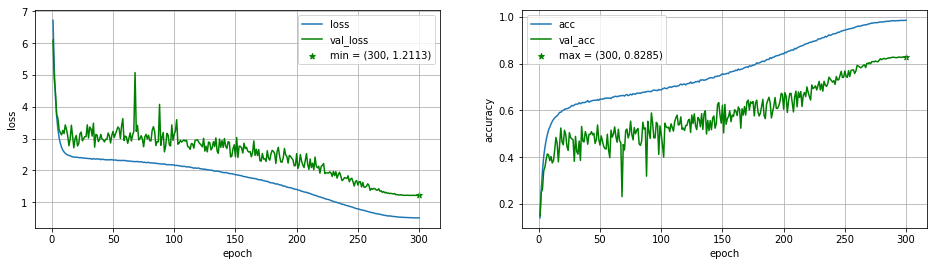

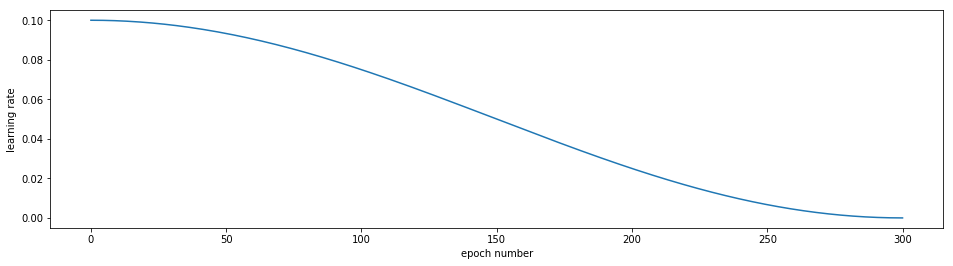

In [13]:
#plot loss and accuracy
plot_history(model.history.history)

#plot learning rate schedule
plt.figure(figsize=(16,4))
plt.plot(np.arange(0,len(lr_scheduler.lr_used))/steps_per_epoch,lr_scheduler.lr_used)
plt.xlabel('epoch number')
plt.ylabel('learning rate')
plt.show()